In [1]:
%pylab inline
import pylab
import seaborn as sns

import numpy as np

import nengo
from nengo.solvers import Solver, LstsqL2
from nengo.utils.numpy import rmse

Populating the interactive namespace from numpy and matplotlib


In [2]:
def count_crossings(signal, points):
    # this can probably be done analytically based on the input frequency
    c = np.zeros(len(points))
    for t in range(1, len(signal)):
        c[(signal[t-1] > points) & (points > signal[t])] += 1
    return c


class ZeroOrderSpikingSolver(Solver):
    
    def __init__(self, intercepts, test_process, test_t=10.0, test_dt=0.001, solver=LstsqL2()):
        # one spike is "dropped" (per second), once every four times the intercept is crossed by the signal
        signal = test_process.run(test_t, dt=test_dt)
        self.mismatch = count_crossings(signal, intercepts) / test_t / 4
        self.solver = solver
        super(ZeroOrderSpikingSolver, self).__init__()
        
    def __call__(self, A, Y, rng=None, E=None):
        for i in range(A.shape[1]):
            #nonzero = A[:, i] > 0
            #num_active = np.sum(nonzero)
            #if num_active > 0:
            #    # distribute the mismatch uniformly along the positive part of the tuning curve
            #    A[nonzero, i] -= self.mismatch[i] * A.shape[0] / float(num_active)
            A[:, i] -= self.mismatch[i]
        return self.solver.__call__(A, Y, rng=rng, E=E)

In [16]:
from nengolib import Network

tau = 0.5
solver = LstsqL2(reg=0.01)
freqs = np.linspace(1, 50, 100)

rmses_default = []
rmses_improved = []
rmses_benchmark = []

for freq in freqs:
    process = nengo.processes.WhiteSignal(5.0, high=freq, y0=0)

    with Network() as model:
        stim = nengo.Node(output=process)

        intercepts = nengo.dists.Uniform(-1, 1).sample(100)
        x = nengo.Ensemble(len(intercepts), 1, intercepts=intercepts, seed=int(freq))
        
        nengo.Connection(stim, x, synapse=None)
        
        p_stim = nengo.Probe(stim, synapse=tau)
        p_neurons = nengo.Probe(x.neurons, synapse=tau)

    with nengo.Simulator(model) as sim:
        sim.run(10.0)
        
    decoders, _ = solver(sim.data[p_neurons], sim.data[p_stim])
    
    with model:
        default = nengo.Node(size_in=1)
        improved = nengo.Node(size_in=1)
        benchmark = nengo.Node(size_in=1)

        nengo.Connection(x, default, synapse=tau, solver=solver)
        nengo.Connection(x, improved, synapse=tau, solver=ZeroOrderSpikingSolver(intercepts, process, solver=solver))
        nengo.Connection(x.neurons, benchmark, synapse=tau, transform=decoders.T)

        p_default = nengo.Probe(default)
        p_improved = nengo.Probe(improved)
        p_benchmark = nengo.Probe(benchmark)
        
    with nengo.Simulator(model) as sim:
        sim.run(process.period)
    
    rmses_default.append(rmse(sim.data[p_stim], sim.data[p_default]))
    rmses_improved.append(rmse(sim.data[p_stim], sim.data[p_improved])) 
    rmses_benchmark.append(rmse(sim.data[p_stim], sim.data[p_benchmark]))

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:

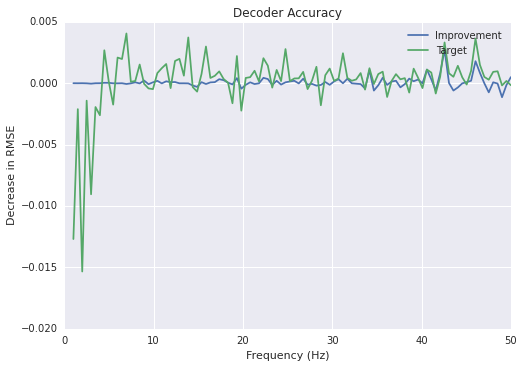

In [17]:
pylab.figure()
pylab.title("Decoder Accuracy")
pylab.plot(freqs, np.asarray(rmses_default) - np.asarray(rmses_improved), label="Improvement")
pylab.plot(freqs, np.asarray(rmses_default) - np.asarray(rmses_benchmark), label="Target")
pylab.xlabel("Frequency (Hz)")
pylab.ylabel("Decrease in RMSE")
pylab.legend()
pylab.show()